# Vanilla Recurrent Neural Network Implementation from Scratch in PyTorch
## This notebook implements the most basic RNN


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import random
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

# Synthetic Data

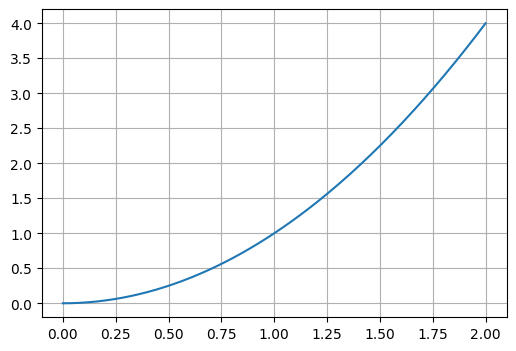

In [2]:
x = torch.linspace(0.0, 2.0, 200)
#freq = 1.0
#y = torch.sin(2*torch.pi*freq*x)

y = x**2

plt.plot(x.tolist(), y.tolist())

In [3]:
y.shape

torch.Size([200])

In [4]:
y.unsqueeze(0).shape

torch.Size([1, 200])

# Model

In [5]:
class VanillaRNN(nn.Module):
    def __init__(self, input_features_size, hidden_size, output_features_size):
        super().__init__()
        
        self.input_to_hidden = nn.Linear(input_features_size+hidden_size, hidden_size)
        self.input_to_output = nn.Linear(input_features_size+hidden_size, output_features_size)
        #self.act_fn = nn.ReLU()
        self.act_fn = nn.Tanh()

    def forward(self, x, hidden_state):
        # (BATCH_SIZE, SEQ_LEN, FEATURES)
        seq_len = x.shape[1]

        output_history = []
        
        # loop through seqeunce of time series features
        for i in range(seq_len):
            # x[:, i, :] -> # (BATCH_SIZE, FEATURES)
            concat = torch.cat((x[:, i, :], hidden_state), dim=1)            
            hidden_state = self.act_fn(self.input_to_hidden(concat))
            output = self.input_to_output(concat)

            # Add dummy sequence dimension (required to concat)
            # (BATCH_SIZE, FEATURES) -> (BATCH_SIZE, 1, FEATURES)
            output_history.append(output.unsqueeze(1))

        # Concant on sequence dimension
        output = torch.cat(output_history, dim=1)
        return output, hidden_state

In [6]:
INPUT_FEATURES_SIZE = 1
HIDDEN_SIZE = 128
OUTPUT_FEATURES_SIZE = 1

BATCH_SIZE = 32
SEQ_LEN = 10
FEATURES_SIZE = 1

In [7]:
rnn = VanillaRNN(INPUT_FEATURES_SIZE, HIDDEN_SIZE, OUTPUT_FEATURES_SIZE)

In [8]:
hidden_state = torch.zeros(BATCH_SIZE, HIDDEN_SIZE)
dummy_data = torch.randn(BATCH_SIZE, SEQ_LEN, FEATURES_SIZE)
            
o, h = rnn(dummy_data, hidden_state)
o.shape, h.shape

(torch.Size([32, 10, 1]), torch.Size([32, 128]))

# Add dummy batch and features dimension

In [9]:
y_dummy = y.unsqueeze(0).unsqueeze(2)
y_dummy.shape

torch.Size([1, 200, 1])

# Process all the sequence at once

In [10]:
hidden_state = torch.zeros(1, HIDDEN_SIZE)

o, h = rnn(y_dummy, hidden_state)
o.shape

torch.Size([1, 200, 1])

# Sliding Window 
*  **NOTE: "LAGS + FORECAST = WINDOW_SIZE" MUST HOLD**

In [11]:
CUSTOM_STEP_SIZE = 5

LAGS_STEPS = 9
FORECAST_STEPS = 1
WINDOW_SIZE = LAGS_STEPS + FORECAST_STEPS

### Slide Methods

In [12]:
# y_dummy.shape[1] -> Sequence length
single_step = range(0, y_dummy.shape[1]-WINDOW_SIZE+1, 1)
window_step = range(0, y_dummy.shape[1]-WINDOW_SIZE+1, WINDOW_SIZE)
custom_step = range(0, y_dummy.shape[1]-WINDOW_SIZE+1, CUSTOM_STEP_SIZE)

In [13]:
for start_index in window_step:
    print(f'Start: {start_index}, End: {start_index+WINDOW_SIZE}')

    # Slice window from data 
    data_window = y_dummy[:, start_index:start_index+WINDOW_SIZE, :]

    # Split current window into lags and forecast
    data_lag = data_window[:, :LAGS_STEPS, :]
    data_forecast = data_window[:, -FORECAST_STEPS:, :]

    print(f'Lag: {data_lag.shape}, Forecast: {data_forecast.shape}')

Start: 0, End: 10
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 10, End: 20
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 20, End: 30
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 30, End: 40
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 40, End: 50
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 50, End: 60
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 60, End: 70
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 70, End: 80
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 80, End: 90
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 90, End: 100
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 100, End: 110
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 110, End: 120
Lag: torch.Size([1, 9, 1]), Forecast: torch.Size([1, 1, 1])
Start: 120, End: 130
Lag: torch.Size([1, 9, 1]),

In [14]:
data_window

tensor([[[3.6464],
         [3.6849],
         [3.7235],
         [3.7624],
         [3.8015],
         [3.8408],
         [3.8803],
         [3.9200],
         [3.9599],
         [4.0000]]])

In [15]:
data_window[:, :LAGS_STEPS, :]

tensor([[[3.6464],
         [3.6849],
         [3.7235],
         [3.7624],
         [3.8015],
         [3.8408],
         [3.8803],
         [3.9200],
         [3.9599]]])

In [16]:
data_window[:, -FORECAST_STEPS:, :]

tensor([[[4.]]])

# Multilayer Autoregressive RNN

In [17]:
class AutoregressiveRNN(nn.Module):
    def __init__(self, input_features_size, hidden_size, output_features_size, forecast_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.forecast_size = forecast_size
        self.num_layers = num_layers

        self.rnn_layers = nn.ModuleList([
            VanillaRNN(input_features_size, hidden_size, output_features_size)
            for _ in range(num_layers)
        ])
    
    def forward(self, x, hidden_state):
        # (BATCH_SIZE, SEQ_LEN, FEATURES)

        for layer in self.rnn_layers:
            x, hidden_state = layer(x, hidden_state)

        # Slice forecast
        x = x[:, -self.forecast_size:, :]
        
        return x, hidden_state

### Initialized Model with Hyperparameters

In [18]:
BATCH_SIZE = 1
INPUT_FEATURES_SIZE = 1
HIDDEN_SIZE = 128
OUTPUT_FEATURES_SIZE = 1
WINDOW_SIZE = 10
LAGS_STEPS = 9
FORECAST_STEPS = 1
NUM_LAYERS = 2

model = AutoregressiveRNN(
    input_features_size=INPUT_FEATURES_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_features_size=OUTPUT_FEATURES_SIZE,
    forecast_size=FORECAST_STEPS,
    num_layers=NUM_LAYERS
)

hidden_state = torch.zeros(BATCH_SIZE, HIDDEN_SIZE)

o, h = model(y_dummy, hidden_state)
# (BATCH_SIZE, FORECAST_STEPS, OUTPUT_FEATURES_SIZE)
o.shape

torch.Size([1, 1, 1])

### Number of parameters

In [19]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [20]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
33,540


# Training With Synthetic Data

### Train/Test Split

In [21]:
SPLIT_RATIO = 0.8

# y_dummy.shape[1] -> len(full_dataset)
train_size = int(SPLIT_RATIO * y_dummy.shape[1])
test_size = y_dummy.shape[1] - train_size

train_size, test_size

(160, 40)

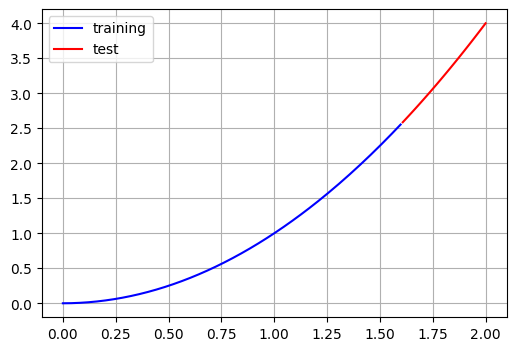

In [22]:
train_dataset = y_dummy[:, :train_size, :]
test_dataset = y_dummy[:, -test_size:, :]
x_train = x[:train_size]
x_test = x[-test_size:]

plt.plot(x_train, train_dataset[0, :, 0], c='blue', label='training')
plt.plot(x_test, test_dataset[0, :, 0], c='red', label='test')
plt.legend()

### Training Functions

In [23]:
def train_iter(model, data, optimizer, criterion, step_iterator, device, batch_size, hidden_size, window_size, lag_steps, forecast_steps):
    model.train()

    avg_loss = []
    
    hidden_state = torch.zeros(batch_size, hidden_size)

    for start_index in step_iterator:

        optimizer.zero_grad()
        
        # Slice window from data 
        data_window = data[:, start_index:start_index+window_size, :]

        # FIXME: LAST EMPTY WINDOW
        if data_window.shape[1] <= 0:
            continue
            
        # Split current window into lags and forecast
        data_lag = data_window[:, :lag_steps, :].to(device)
        data_forecast = data_window[:, -forecast_steps:, :].to(device)
    
        forecast_pred, h = model(data_lag, hidden_state)
        
        loss = criterion(forecast_pred, data_forecast)
        
        loss.backward()
        optimizer.step()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, data, criterion, step_iterator, device, batch_size, hidden_size, window_size, lag_steps, forecast_steps):
    model.eval()

    avg_loss = []
    predictions = []
    
    hidden_state = torch.zeros(batch_size, hidden_size)

    for start_index in step_iterator:
        
        # Slice window from data 
        data_window = data[:, start_index:start_index+window_size, :]

        # FIXME: LAST EMPTY WINDOW
        if data_window.shape[1] <= 0:
            continue
    
        # Split current window into lags and forecast
        data_lag = data_window[:, :lag_steps, :].to(device)
        data_forecast = data_window[:, -forecast_steps:, :].to(device)
    
        forecast_pred, h = model(data_lag, hidden_state)
        
        loss = criterion(forecast_pred, data_forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [24]:
LEARNING_RATE = 0.001

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE
)

# LOSS
criterion = nn.MSELoss()

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(f'USING DEVICE: {device}')

device = 'cpu'

In [25]:
NUM_EPOCHS = 8

model.to(device)

for epoch in range(1, NUM_EPOCHS+1):
    
    avg_train_loss = train_iter(
        model=model, 
        data=train_dataset, 
        optimizer=optimizer, 
        criterion=criterion, 
        step_iterator=window_step, 
        device=device, 
        batch_size=1, 
        hidden_size=HIDDEN_SIZE,
        window_size=WINDOW_SIZE, 
        lag_steps=LAGS_STEPS, 
        forecast_steps=FORECAST_STEPS
    )

    avg_test_loss, _ = eval_iter(
        model=model, 
        data=test_dataset, 
        criterion=criterion, 
        step_iterator=window_step, 
        device=device, 
        batch_size=1, 
        hidden_size=HIDDEN_SIZE,
        window_size=WINDOW_SIZE, 
        lag_steps=LAGS_STEPS, 
        forecast_steps=FORECAST_STEPS,
    )

    print(f'Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}')

Training loss: 0.0362, Testing Loss: 0.8796
Training loss: 2.0873, Testing Loss: 9.8921
Training loss: 0.6936, Testing Loss: 6.1856
Training loss: 0.6812, Testing Loss: 4.9618
Training loss: 0.1664, Testing Loss: 1.7136
Training loss: 0.4589, Testing Loss: 2.9747
Training loss: 0.4412, Testing Loss: 2.9050
Training loss: 0.4543, Testing Loss: 3.9477


# Testing

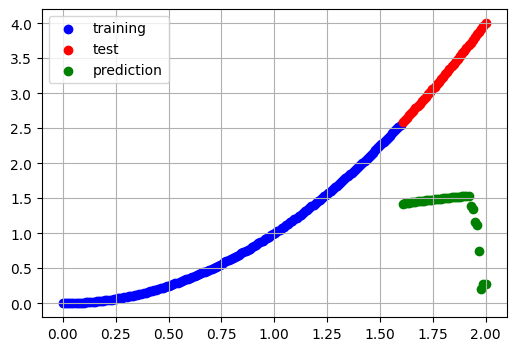

In [26]:
_, pred = eval_iter(
    model=model, 
    data=test_dataset, 
    criterion=criterion, 
    step_iterator=single_step, 
    device=device, 
    batch_size=1, 
    hidden_size=HIDDEN_SIZE,
    window_size=WINDOW_SIZE, 
    lag_steps=LAGS_STEPS, 
    forecast_steps=FORECAST_STEPS,
)

pred_flat = []

for p in pred:
    pred_flat.extend(p.flatten().tolist())

plt.scatter(x_train, train_dataset[0, :, 0], c='blue', label='training')
plt.scatter(x_test, test_dataset[0, :, 0], c='red', label='test')
plt.scatter(x_test, pred_flat, c='green', label='prediction')
plt.legend()